In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data preparded in EDA workbook

In [2]:
df = pd.read_csv('./input_file.csv')

Dropping Patient ID number.

In [3]:
df.columns

Index(['patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'readmitted', 'Up', 'Steady', 'Down',
       'diagnosis_count', 'diabetes_med_others', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male',
       'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)',
       'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)',
       'age_[90-100)', 'admission_type_id_1', 'admission_type_id_2',
       'admission_type_id_3', 'discharge_disposition_id_2',
       'discharge_disposition_id_3', 'discharge_disposition_id_6',
       'discharge_disposition_id_18', 'discharge_disposition_id_0',
       'admission_source_id_1', 'admission_source_id_2',
       'admission_source_id_30', 'admission_source

In [5]:
df = df.drop(columns = ['patient_nbr', 'race_Asian','race_Caucasian', 'race_Hispanic', 'race_Other'])

In [6]:
df.shape

(97108, 76)

### Collapsing <30 days and >30 days readmits to one readmits and turning the problem to binary classification.  

In [7]:
### creating a map dictonary ###

readmit_map = {'<30':1, '>30':1, 'NO':0}


df['readmitted'] = df['readmitted'].map(readmit_map)

In [8]:
# Import libraries needed for models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [9]:
X = df.drop(columns=['readmitted'])
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state = 42
)
Z_train = X_train
Z_test = X_test

## Models: 
#### Running six models and outputting accuracry score at the end of the runs for comparison

### Logistic Regression

#### Exploring Pipelines & PCA
Checking if a reduced data set is effective for Logistic Regression

In [10]:
### Source: https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 74],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(Z_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.622):
{'logistic__C': 21.54434690031882, 'pca__n_components': 74}


Use of PCA reduces varaibles by approx. 5% and reduces interpretability of the model. No PCA to be used.

In [11]:
### Instantiate & Fit Multinomial Logistic Regression ###

lr = LogisticRegression( max_iter=10000, penalty = 'elasticnet', l1_ratio = 0.25, solver='saga').fit(Z_train, y_train)

In [12]:
#Output predictions to output df
output = pd.DataFrame(y_test)

output['lr_predicts' ] = lr.predict(Z_test)


In [13]:
pd.crosstab(output['readmitted'], output['lr_predicts'])

lr_predicts,0,1
readmitted,,
0,9626,3087
1,6183,5381


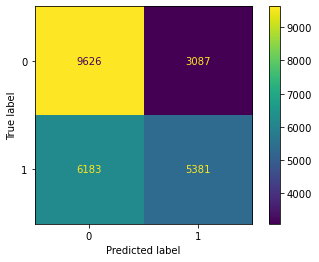

In [14]:
plot_confusion_matrix(lr,Z_test, y_test, values_format='d');

#### Decision Tree

In [15]:
### Decision Tree Classifier ###

## Import
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [16]:
### Instantiate and Fit
random =30
dt = DecisionTreeClassifier(random_state = random, max_depth = 5).fit(Z_train, y_train)

In [17]:
### Output predictions to output df
output['dt_predicts' ] = dt.predict(Z_test)

In [18]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['dt_predicts'])

dt_predicts,0,1
readmitted,,
0,9477,3236
1,6026,5538


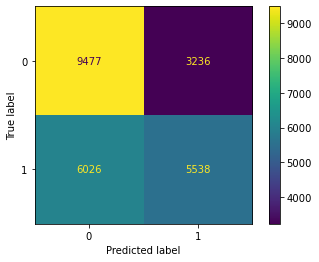

In [19]:
### Plot Confusion Matrix
plot_confusion_matrix(dt,Z_test, y_test, values_format='d');

#### KNN Classifier

In [20]:
### KNN Classifier ###

## Import ##
from sklearn.neighbors import KNeighborsClassifier

In [21]:
#KNN Classifier

## Instantiate & Fit KNN Classifier 
knn = KNeighborsClassifier().fit(Z_train, y_train)


In [22]:
### Output predictions to output df
output['knn_predicts' ] = knn.predict(Z_test)

In [23]:
pd.crosstab(output['readmitted'], output['knn_predicts'])

knn_predicts,0,1
readmitted,,
0,8067,4646
1,6132,5432


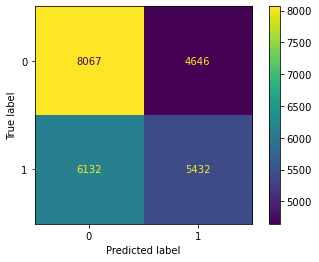

In [24]:
plot_confusion_matrix(knn,Z_test, y_test, values_format='d');

#### Bagging

In [25]:
### Bagging and Random Forests ##

## Import ##
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier


In [26]:
### Instantiate and Fit Bagging Classifier ###
bag = BaggingClassifier(random_state = random).fit(Z_train, y_train)

In [27]:
### Output predictions to output df
output['bag_predicts' ] = bag.predict(Z_test)

In [28]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['bag_predicts'])

bag_predicts,0,1
readmitted,,
0,8912,3801
1,6223,5341


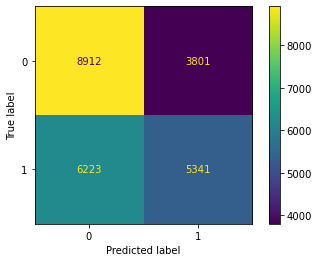

In [29]:
### Plot Confusion Matrix
plot_confusion_matrix(bag,Z_test, y_test, values_format='d');

#### Random Forest

In [30]:
### Random Forest ###

### Instantiate and Fit Random Forest Classifier ###
rf = RandomForestClassifier(n_estimators=500).fit(Z_train, y_train)

In [31]:
### Output predictions to output df
output['rf_predicts' ] = rf.predict(Z_test)

In [32]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['rf_predicts'])

rf_predicts,0,1
readmitted,,
0,8813,3900
1,5303,6261


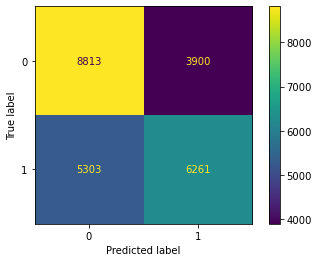

In [33]:
### Plot Confusion Matrix
plot_confusion_matrix(rf,Z_test, y_test, values_format='d');

In [34]:
rf_params = {
    'n_estimators': [100, 150, 200, 500],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split' : [2000,4000,8000]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(Z_train, y_train)
print(gs.best_score_)
gs.best_params_

0.6254754442489957


{'max_depth': None, 'min_samples_split': 2000, 'n_estimators': 200}

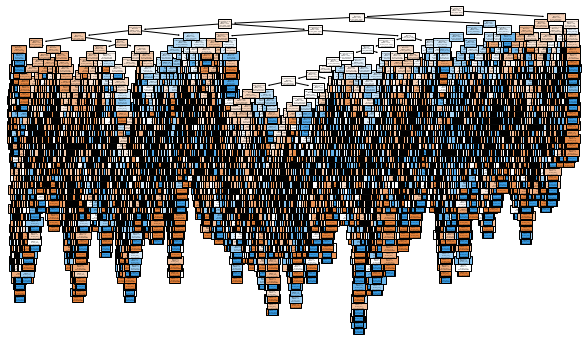

In [35]:
# Plot the tree


plt.figure(figsize= (10,6))
plot_tree(rf.estimators_[0], feature_names=Z_train.columns,
         class_names = ['Not Readmit', 'Readmit'], filled = True);

#### Linear SVM Classifier

In [36]:
### SVM Linear ###

## Import ##
from sklearn.svm import LinearSVC

In [37]:
### Instantiate and Fit SVM Linear Classifier ###
svc = LinearSVC(max_iter=20000).fit(Z_train, y_train)

C:\Users\Rhino\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [38]:
### Output predictions to output df
output['svc_predicts' ] = svc.predict(Z_test)


In [39]:
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['svc_predicts'])

svc_predicts,0,1
readmitted,,
0,9846,2867
1,6431,5133


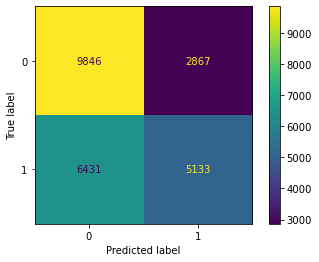

In [40]:
### Plot Confusion Matrix
plot_confusion_matrix(svc,Z_test, y_test, values_format='d');

#### Stochastic Gradient Descent (SGD)

In [41]:
from sklearn.linear_model import SGDClassifier

In [42]:
### Instantiate and Fit SVM Linear Classifier ###
sgdc = SGDClassifier(max_iter=1000, tol=0.001).fit(Z_train, y_train)

In [43]:
### Output predictions to output df
output['sgdc_predicts' ] = sgdc.predict(Z_test)
### Cross-tab Confusion Matrix
pd.crosstab(output['readmitted'], output['sgdc_predicts'])

sgdc_predicts,0,1
readmitted,,
0,12218,495
1,10232,1332


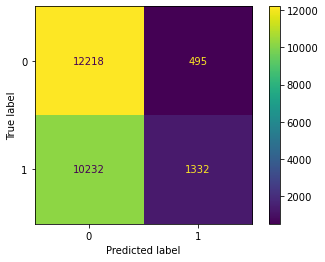

In [44]:
### Plot Confusion Matrix
plot_confusion_matrix(sgdc,Z_test, y_test, values_format='d');

In [45]:
print(f"Logisitic Regression: {round(lr.score(Z_test, y_test),4)}")
print(f"Decision Tree: {round(dt.score(Z_test, y_test), 4)}")
print(f"KNN Classifier: {round(knn.score(Z_test, y_test), 4)}")
print(f"Random Forest: {round(rf.score(Z_test, y_test), 4)}")
print(f"Bagging: {round(bag.score(Z_test, y_test), 4)}")
print(f"Support Vector Classifier: {round(svc.score(Z_test, y_test), 4)}")
print(f"Stochastic Gradient Descent : {round(sgdc.score(Z_test, y_test), 4)}")   

Logisitic Regression: 0.6182
Decision Tree: 0.6185
KNN Classifier: 0.556
Random Forest: 0.6209
Bagging: 0.5871
Support Vector Classifier: 0.617
Stochastic Gradient Descent : 0.5581


#### Exporting Probability of Admits for each of the Classifiers & creating deciles based on the probabilities

_Excludes Linear SVM and Gradient Descent_

In [46]:
### Pushing Logisitic Regression probabilities to output df

output['lr_prob_1'] = lr.predict_proba(Z_test)[:,1]

## Sorting by prob_1

output.sort_values(by = 'lr_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['lr_decile_rank'] = pd.qcut(output['lr_prob_1'], 10, labels = False)

In [47]:
### Pushing Randon Forest probabilities to output df

output['rf_prob_1'] = rf.predict_proba(Z_test)[:,1]

## Sorting by prob_1

output.sort_values(by = 'rf_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['rf_decile_rank'] = pd.qcut(output['rf_prob_1'], 10, duplicates ='raise',labels = False)

In [48]:
### Pushing Bagging probabilities to output df

output['bag_prob_1'] = bag.predict_proba(Z_test)[:,1]

## Sorting by prob_1

output.sort_values(by = 'bag_prob_1', ascending = False, inplace=True)

# adding Decile_rank column to the DataFrame 

output['bag_decile_rank'] = pd.qcut(output['bag_prob_1'].rank(method='first'), 10, labels = False)


In [49]:
### Pushing Decision Tree probabilities to output df

output['dt_prob_1'] = dt.predict_proba(Z_test)[:,1]


# adding Decile_rank column to the DataFrame 

output['dt_decile_rank'] = pd.qcut(output['dt_prob_1'].rank(method='first'), 10, labels = False)

In [50]:
### Pushing Decision Tree probabilities to output df

output['knn_prob_1'] = knn.predict_proba(Z_test)[:,1]


# adding Decile_rank column to the DataFrame 

output['knn_decile_rank'] = pd.qcut(output['knn_prob_1'].rank(method='first'), 10, labels = False)

In [51]:
###Exporting all ranks and probabilities)
output.to_csv('./model_output.csv', index=False)

In [52]:
coefficients = pd.DataFrame({'Features': X.columns,
                             'Coefficients': lr.coef_[0]})\
                                .sort_values('Coefficients', ascending=False)
# If interested in hiding the index in the notebook output
# coefficients.style.hide_index()

In [53]:
###Exporting all ranks and probabilities)
coefficients.to_csv('./model_coeff.csv', index=False)

In [54]:
Z_train.shape, y_train.shape, Z_test.shape, y_test.shape

((72831, 75), (72831,), (24277, 75), (24277,))

### Using Neural Network

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [56]:
model_dropout =Sequential()
model_dropout.add(Dense(80,  ## No of neurons in the first layer Rule of thumbs base 2 # > no of features
          input_shape = (75, ), ##shape of one sample of the training data
          activation= 'relu')) ##rectified linear unit -- very popular & common
model_dropout.add(Dropout(0.2))  ##Add here

model_dropout.add(Dense(160, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(80, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(32, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(16, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(8, activation = 'relu'))
model_dropout.add(Dropout(0.2))  ##Add droupout

# model_dropout.add(Dense(4, activation = 'relu'))
# model_dropout.add(Dropout(0.2))  ##Add droupout

model_dropout.add(Dense(1, activation = 'sigmoid'))
          
# Compile it

# What are the two primary components of compiling the NN? 
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




In [57]:
# Fit the model
# What are all the possible components here? What are the areas we explored on Thursday?

history_dropout= model_dropout.fit(Z_train, y_train, validation_data=(Z_test, y_test), epochs=30, batch_size=512, verbose=0)


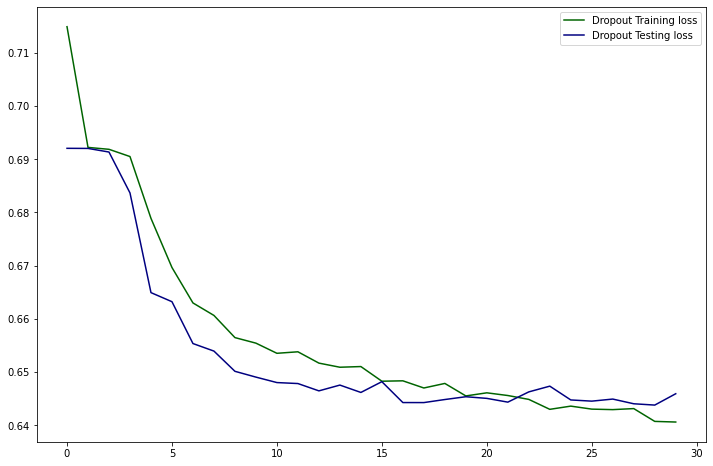

In [58]:
# Visualize loss
train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='navy')
plt.legend();

Though the Loss function converges for test and train, the model shows no major improvement over Logisitic Regression which shall be retained.